# Model recovery attack: `news-popularity`

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mra
from mra import *
import models
from models import *

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

def map_y(y):
    if y >= 3400:
        return 4.0
    elif y >= 1800:
        return 3.0
    elif y >= 1200:
        return 2.0
    elif y >= 800:
        return 1.0
    else:
        return 0.0

df = pd.read_csv('../datasets/news-popularity.csv').sample(frac=1)
df = df.drop(columns=["url"])
xy = df.to_numpy()
x = xy[:,1:-1] # remove the first feature as it is not predictive
y = xy[:,-1]
x = (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))
y = np.array([map_y(i) for i in y]).reshape((len(x), 1))
train_ds = make_dataset(x, y, lambda t: t)

2022-03-30 11:01:59.045638: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-30 11:02:00.284436: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10545 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:3b:00.0, compute capability: 7.0
2022-03-30 11:02:00.285672: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10545 MB memory:  -> device: 1, name: NVIDIA TITAN V, pci bus id: 0000:5e:00.0, compute capability: 7.0


In [4]:
main = {}

for split in [2,3,4]:
    print("split = {}".format(split))
    main[split] = mra(train_ds)
    make_f, make_g, make_generator = models.make_mlp(
        attr_num=58,
        class_num=5,
        split=split,
        fg_units=256,
        fg_act="relu",
        generator_units=[1024,512,256,128]
    )
    main[split].train(
        make_f,
        make_g,
        loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
        batch_size=32,
        epoch=5,
        lr=0.001,
        verbose=True, log_every=2000
    )

split = 2
Iteration 2000: Training loss: 1.5317
Iteration 4000: Training loss: 1.5084
Iteration 6000: Training loss: 1.4968
split = 3
Iteration 2000: Training loss: 1.5285
Iteration 4000: Training loss: 1.5066
Iteration 6000: Training loss: 1.4965
split = 4
Iteration 2000: Training loss: 1.5291
Iteration 4000: Training loss: 1.5079
Iteration 6000: Training loss: 1.4968


In [6]:
log_attack = {}
for split in [4,3,2]:
    print("split level = {}".format(split))
    log_attack[split] = main[split].attack(
        attack_iter=100,
        make_generator=make_generator,
        input_noise="normal",
        input_z=True,
        model_leak=True,
        lr_x=0.0001,
        lr_f=0.00001,
        epoch=50,
        iter_x=40,
        iter_f=1,
        verbose=True, log_every=1
    )

split level = 4
Iteration 0001: RG-uniform: 0.2567, RG-normal: 0.2508, reconstruction validation: 0.1583
Iteration 0002: RG-uniform: 0.2627, RG-normal: 0.2385, reconstruction validation: 0.1571
Iteration 0003: RG-uniform: 0.2611, RG-normal: 0.2479, reconstruction validation: 0.1437
Iteration 0004: RG-uniform: 0.2596, RG-normal: 0.2383, reconstruction validation: 0.1477
Iteration 0005: RG-uniform: 0.2661, RG-normal: 0.2430, reconstruction validation: 0.1513
Iteration 0006: RG-uniform: 0.2591, RG-normal: 0.2396, reconstruction validation: 0.1540
Iteration 0007: RG-uniform: 0.2621, RG-normal: 0.2476, reconstruction validation: 0.1476
Iteration 0008: RG-uniform: 0.2570, RG-normal: 0.2484, reconstruction validation: 0.1544
Iteration 0009: RG-uniform: 0.2556, RG-normal: 0.2343, reconstruction validation: 0.1438
Iteration 0010: RG-uniform: 0.2635, RG-normal: 0.2365, reconstruction validation: 0.1442
Iteration 0011: RG-uniform: 0.2656, RG-normal: 0.2429, reconstruction validation: 0.1559
Itera

Iteration 0093: RG-uniform: 0.2696, RG-normal: 0.2412, reconstruction validation: 0.1526
Iteration 0094: RG-uniform: 0.2576, RG-normal: 0.2406, reconstruction validation: 0.1701
Iteration 0095: RG-uniform: 0.2634, RG-normal: 0.2438, reconstruction validation: 0.1686
Iteration 0096: RG-uniform: 0.2671, RG-normal: 0.2519, reconstruction validation: 0.1763
Iteration 0097: RG-uniform: 0.2597, RG-normal: 0.2532, reconstruction validation: 0.1764
Iteration 0098: RG-uniform: 0.2536, RG-normal: 0.2404, reconstruction validation: 0.1650
Iteration 0099: RG-uniform: 0.2619, RG-normal: 0.2297, reconstruction validation: 0.1789
Iteration 0100: RG-uniform: 0.2658, RG-normal: 0.2442, reconstruction validation: 0.1771
split level = 3
Iteration 0001: RG-uniform: 0.2580, RG-normal: 0.2406, reconstruction validation: 0.1221
Iteration 0002: RG-uniform: 0.2713, RG-normal: 0.2440, reconstruction validation: 0.1083
Iteration 0003: RG-uniform: 0.2754, RG-normal: 0.2431, reconstruction validation: 0.1047
Itera

Iteration 0085: RG-uniform: 0.2668, RG-normal: 0.2422, reconstruction validation: 0.0942
Iteration 0086: RG-uniform: 0.2593, RG-normal: 0.2401, reconstruction validation: 0.0878
Iteration 0087: RG-uniform: 0.2698, RG-normal: 0.2501, reconstruction validation: 0.0820
Iteration 0088: RG-uniform: 0.2610, RG-normal: 0.2477, reconstruction validation: 0.0790
Iteration 0089: RG-uniform: 0.2682, RG-normal: 0.2397, reconstruction validation: 0.0814
Iteration 0090: RG-uniform: 0.2695, RG-normal: 0.2455, reconstruction validation: 0.0725
Iteration 0091: RG-uniform: 0.2660, RG-normal: 0.2353, reconstruction validation: 0.0751
Iteration 0092: RG-uniform: 0.2633, RG-normal: 0.2330, reconstruction validation: 0.0793
Iteration 0093: RG-uniform: 0.2596, RG-normal: 0.2405, reconstruction validation: 0.0718
Iteration 0094: RG-uniform: 0.2585, RG-normal: 0.2412, reconstruction validation: 0.0728
Iteration 0095: RG-uniform: 0.2570, RG-normal: 0.2436, reconstruction validation: 0.0794
Iteration 0096: RG-un

Iteration 0077: RG-uniform: 0.2589, RG-normal: 0.2376, reconstruction validation: 0.0353
Iteration 0078: RG-uniform: 0.2591, RG-normal: 0.2350, reconstruction validation: 0.0323
Iteration 0079: RG-uniform: 0.2544, RG-normal: 0.2409, reconstruction validation: 0.0239
Iteration 0080: RG-uniform: 0.2563, RG-normal: 0.2376, reconstruction validation: 0.0264
Iteration 0081: RG-uniform: 0.2599, RG-normal: 0.2471, reconstruction validation: 0.0243
Iteration 0082: RG-uniform: 0.2568, RG-normal: 0.2310, reconstruction validation: 0.0259
Iteration 0083: RG-uniform: 0.2534, RG-normal: 0.2476, reconstruction validation: 0.0281
Iteration 0084: RG-uniform: 0.2535, RG-normal: 0.2421, reconstruction validation: 0.0231
Iteration 0085: RG-uniform: 0.2626, RG-normal: 0.2469, reconstruction validation: 0.0303
Iteration 0086: RG-uniform: 0.2636, RG-normal: 0.2338, reconstruction validation: 0.0228
Iteration 0087: RG-uniform: 0.2588, RG-normal: 0.2515, reconstruction validation: 0.0247
Iteration 0088: RG-un

In [7]:
import pickle
with open('./log/news.pkl', 'wb') as f:
    pickle.dump(log_attack, f)

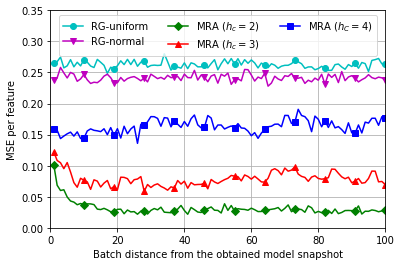

In [8]:
import matplotlib.pyplot as plt

plt.xlim([0,100])
plt.ylim([0,0.35])
plt.grid()
plt.ylabel('MSE per feature')
plt.xlabel('Batch distance from the obtained model snapshot')
ran = [i+1 for i in range(100)]
plt.plot(
    ran, log_attack[2][:,0], 'co-',
    ran, log_attack[2][:,1], 'mv-',
    ran, log_attack[2][:,2], 'gD-',
    ran, log_attack[3][:,2], 'r^-',
    ran, log_attack[4][:,2], 'bs-',
    markevery=np.arange(0, 101, 9))
plt.legend(['RG-uniform', 'RG-normal', 'MRA ($h_c=2$)', 'MRA ($h_c=3$)', 'MRA ($h_C=4$)'], loc='upper center', ncol=3)
plt.savefig("fig/news.pdf", bbox_inches='tight')